In [1]:
import cvxpy as cvx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import linear_model as lm

%matplotlib inline

# Exploratory data analysis

Read in the *Engel food expenditure* data from the R package [`quantreg`](https://cran.r-project.org/package=quantreg).

In [2]:
engel = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/quantreg/engel.csv', index_col=0)

In [3]:
engel.head()

,income,foodexp
1,420.157651,255.839425
2,541.411707,310.958667
3,901.157457,485.680014
4,639.080229,402.997356
5,750.875606,495.560775


## Scatter plot of income vs food expenditure

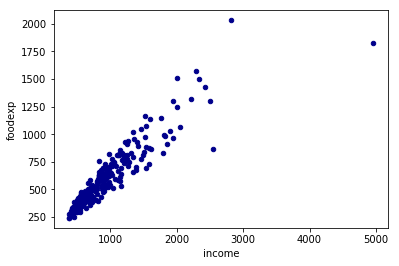

In [4]:
engel.plot.scatter(x='income', y='foodexp', color='darkblue')

# Modelling

Define model matrix and outcome.

In [5]:
X = np.hstack((
    np.ones(engel.shape[0])[:, np.newaxis],
    engel['income'][:, np.newaxis]
))
y = engel['foodexp'].values

In [6]:
X[:5, :]

array([[  1.        , 420.15765084],
       [  1.        , 541.41170672],
       [  1.        , 901.15745665],
       [  1.        , 639.08022869],
       [  1.        , 750.87560583]])

In [7]:
y[:5]

array([255.83942459, 310.95866706, 485.68001417, 402.99735554,
       495.56077493])

Define a variable `betas` for the regression coefficients and a parameter `tau` representing the quantile.

In [8]:
betas = cvx.Variable(X.shape[1])
tau = cvx.Parameter()

Define variables `u` and `v` for the positive and negative deviations.

In [9]:
u = cvx.Variable(X.shape[0], nonneg=True)
v = cvx.Variable(X.shape[0], nonneg=True)

Define the objective function and constraints.

In [10]:
objective = cvx.sum(tau * u) + cvx.sum((1-tau) * v)
constraints = [cvx.matmul(X, betas) + u - v == y]

Set a value for $\tau$.

In [11]:
tau.value = 0.5

Define and solve the quantile regression problem.

In [12]:
problem = cvx.Problem(cvx.Minimize(objective), constraints)
problem.solve()

8781.383825942727

Extract the regression coefficients.

In [13]:
betas.value

array([77.09390334,  0.56467913])

Define a new range of values to predict over.

In [14]:
n_pred = 100
X_pred = np.hstack((
    np.ones(n_pred)[:, np.newaxis],
    np.linspace(min(engel['income']), max(engel['income']), n_pred)[:, np.newaxis]
))

In [15]:
X_pred[:5, :]

array([[  1.        , 377.05836885],
       [  1.        , 423.3286179 ],
       [  1.        , 469.59886694],
       [  1.        , 515.86911599],
       [  1.        , 562.13936504]])

In [16]:
y_pred = X_pred @ betas.value

In [17]:
y_pred[:5]

array([290.01089332, 316.13873709, 342.26658085, 368.39442462,
       394.52226839])

Plot the original data and quantile regression line.

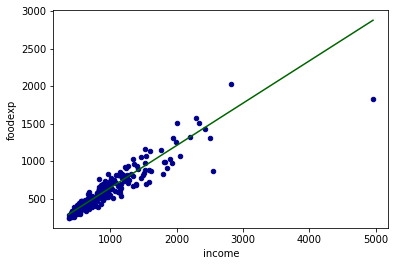

In [18]:
engel.plot.scatter(x='income', y='foodexp', color='darkblue')
plt.plot(X_pred[:, 1], y_pred, color='darkgreen')

Compare with the linear regression (OLS) line.

In [19]:
betas_lr = lm.LinearRegression(fit_intercept=False).fit(X, y).coef_

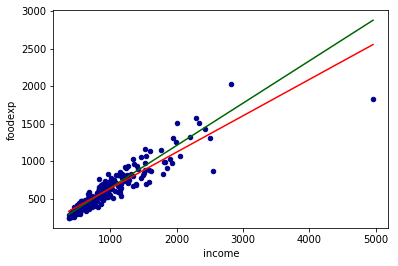

In [20]:
engel.plot.scatter(x='income', y='foodexp', color='darkblue')
plt.plot(X_pred[:, 1], y_pred, color='darkgreen')
plt.plot(X_pred[:, 1], X_pred @ betas_lr, color='red')